# 1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

from mlflow import log_metric, log_param, log_artifacts


In [2]:
keras.__version__

'2.4.0'

In [3]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [5]:
def prepare_image(file):
    img_path = 'dataset/train_spl/1/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

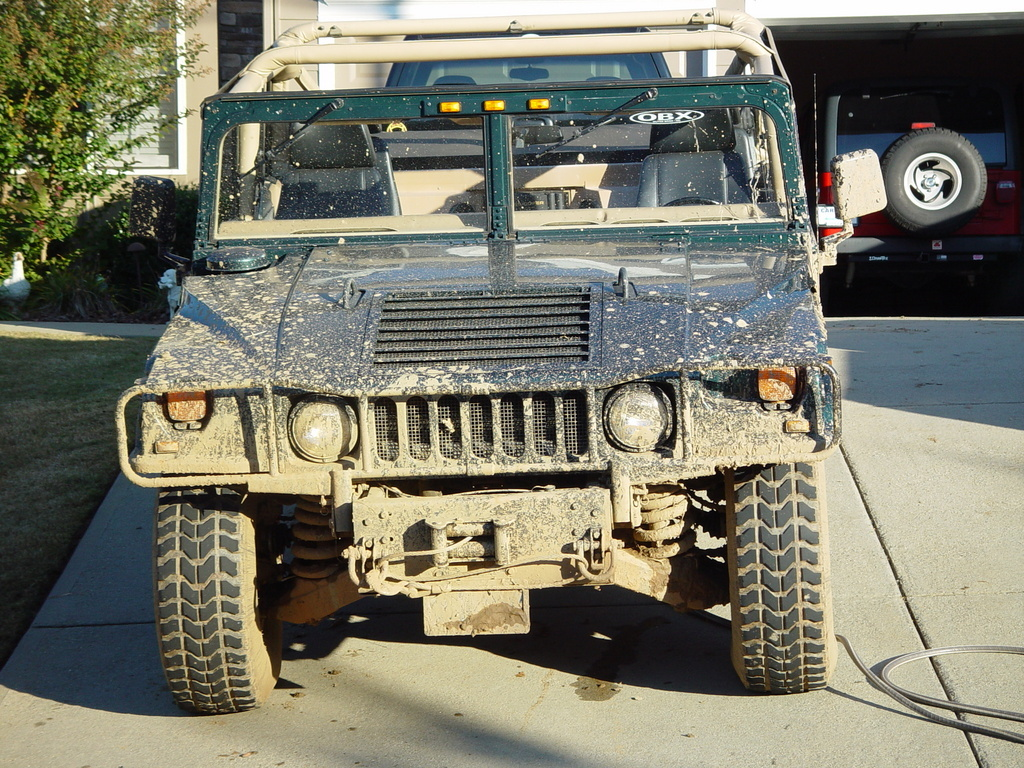

In [6]:
from IPython.display import Image
Image(filename='dataset/train_spl/1/000001.JPG', width=300,height=200) 

In [7]:
preprocessed_image = prepare_image('000001.JPG')
predictions = mobile.predict(preprocessed_image)

In [8]:
results = imagenet_utils.decode_predictions(predictions)

In [9]:
results

[[('n03594945', 'jeep', 0.45802656),
  ('n04389033', 'tank', 0.33695903),
  ('n03478589', 'half_track', 0.087160505),
  ('n02704792', 'amphibian', 0.027824344),
  ('n03769881', 'minibus', 0.01929703)]]

# 2

In [10]:
train_path = 'dataset/train_spl'
valid_path = 'dataset/val_spl'
test_path = 'dataset/test_spl'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 9791 images belonging to 196 classes.
Found 3312 images belonging to 196 classes.
Found 3082 images belonging to 196 classes.


# 3

In [11]:
len(mobile.layers)

93

In [12]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [13]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [14]:
x = mobile.layers[-6].output
output = Dense(units=196, activation='softmax')(x)

In [15]:
model = Model(inputs=mobile.input, outputs=output)

In [16]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## Train the model

In [18]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
980/980 - 260s - loss: 4.2605 - accuracy: 0.1514 - val_loss: 3.0160 - val_accuracy: 0.3493
Epoch 2/30
980/980 - 263s - loss: 2.1725 - accuracy: 0.5848 - val_loss: 1.9574 - val_accuracy: 0.5655
Epoch 3/30
980/980 - 257s - loss: 1.2379 - accuracy: 0.7946 - val_loss: 1.5008 - val_accuracy: 0.6540
Epoch 4/30
980/980 - 253s - loss: 0.7565 - accuracy: 0.8966 - val_loss: 1.2561 - val_accuracy: 0.7020
Epoch 5/30
980/980 - 253s - loss: 0.4570 - accuracy: 0.9543 - val_loss: 1.1081 - val_accuracy: 0.7228
Epoch 6/30
980/980 - 253s - loss: 0.2867 - accuracy: 0.9809 - val_loss: 1.0414 - val_accuracy: 0.7322
Epoch 7/30
980/980 - 253s - loss: 0.1723 - accuracy: 0.9929 - val_loss: 0.9763 - val_accuracy: 0.7470
Epoch 8/30
980/980 - 253s - loss: 0.1201 - accuracy: 0.9945 - val_loss: 0.9667 - val_accuracy: 0.7461
Epoch 9/30
980/980 - 254s - loss: 0.0899 - accuracy: 0.9949 - val_loss: 0.9172 - val_accuracy: 0.7639
Epoch 10/30
980/980 - 256s - loss: 0.0681 - accuracy: 0.9955 - val_loss: 0.9179 - 

In [20]:
test_labels = test_batches.classes

In [21]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

In [23]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [24]:
test_batches.class_indices

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '103': 5,
 '104': 6,
 '105': 7,
 '106': 8,
 '107': 9,
 '108': 10,
 '109': 11,
 '11': 12,
 '110': 13,
 '111': 14,
 '112': 15,
 '113': 16,
 '114': 17,
 '115': 18,
 '116': 19,
 '117': 20,
 '118': 21,
 '119': 22,
 '12': 23,
 '120': 24,
 '121': 25,
 '122': 26,
 '123': 27,
 '124': 28,
 '125': 29,
 '126': 30,
 '127': 31,
 '128': 32,
 '129': 33,
 '13': 34,
 '130': 35,
 '131': 36,
 '132': 37,
 '133': 38,
 '134': 39,
 '135': 40,
 '136': 41,
 '137': 42,
 '138': 43,
 '139': 44,
 '14': 45,
 '140': 46,
 '141': 47,
 '142': 48,
 '143': 49,
 '144': 50,
 '145': 51,
 '146': 52,
 '147': 53,
 '148': 54,
 '149': 55,
 '15': 56,
 '150': 57,
 '151': 58,
 '152': 59,
 '153': 60,
 '154': 61,
 '155': 62,
 '156': 63,
 '157': 64,
 '158': 65,
 '159': 66,
 '16': 67,
 '160': 68,
 '161': 69,
 '162': 70,
 '163': 71,
 '164': 72,
 '165': 73,
 '166': 74,
 '167': 75,
 '168': 76,
 '169': 77,
 '17': 78,
 '170': 79,
 '171': 80,
 '172': 81,
 '173': 82,
 '174': 83,
 '175': 84,


Confusion matrix, without normalization
[[14  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  1  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 11]]


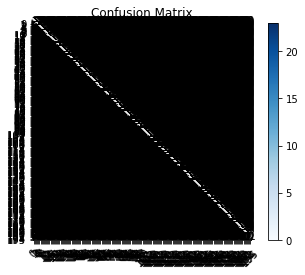

In [25]:
cm_plot_labels = list(range(0, 196))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Save Model

In [28]:
model.save("M_MobileNet.h5")